# Network LST


## Part1. Fetching the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import os
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import dask.dataframe as dd
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
import matplotlib.pyplot as plt
import random


In [ ]:
import torch

In [ ]:
import zipfile

# Replace the zip_file_path with the path to the zip file in your Google Drive

zip_file_pathLST = '/content/drive/MyDrive/dataLSTTensor.zip'
zip_file_paths = [zip_file_pathLST]

# Replace the destination_folder with the path of the folder where you want to extract the contents

destination_folderLST = '/content/dataLST'

destination_folders = [destination_folderLST]

In [ ]:
# Unzip the file

for i in range(len(destination_folders)):
  with zipfile.ZipFile(zip_file_paths[i], 'r') as zip_ref:
      zip_ref.extractall(destination_folders[i])


In [ ]:
sampleCoordinatesLSTIDArrayPositionDf_file = '/content/drive/MyDrive/sampleCoordinatesLSTIDArrayPositionDf.parquet'
sampleCoordinatesLSTIDArrayPositionDf = dd.read_parquet(sampleCoordinatesLSTIDArrayPositionDf_file).compute()


# Part 2 Custom Dataset

In [ ]:

class CustomRasterDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dataFrame, file_path, file_extension,windowSize,re_scale = False,new_min = -1,new_max = 1):
        'Initialization'
        self.re_scale = re_scale
        self.new_min  = new_min
        self.new_max = new_max
        self.dataFrame = dataFrame
        self.file_path = file_path
        self.file_extension = file_extension
        self.windowSize = windowSize
        self.offset = self.windowSize // 2


    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dataFrame)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID =  self.dataFrame.iloc[index]['ID'] # str(ID).rstrip('.0')

        x = self.dataFrame.iloc[index]['x'] + random.choice([-2, -1, 0, 1, 2])
        y = self.dataFrame.iloc[index]['y'] + random.choice([-2, -1, 0, 1, 2])
        # Load data and get label
        fullArray = torch.load(self.file_path+ID+self.file_extension)
        # Determine the window for the square
        left = x - self.offset
        right = x + (self.offset + 1)
        top = y - self.offset
        bottom = y + (self.offset + 1)
        X = fullArray[left:right,top:bottom].clone().detach()  # Access value in gpu_dictElevation
        # if self.re_scale:
          # X =  re_scale(X,self.new_min,self.new_max)
        return X.unsqueeze(0)

In [ ]:
file_pathLST = '/content/dataLST/'

In [ ]:

batch_sizeLST = 32

In [ ]:
file_extension = '.pt'
num_workers = 2

In [ ]:
windowSizeLST = 23
datasetLST = CustomRasterDataset(sampleCoordinatesLSTIDArrayPositionDf, file_pathLST, file_extension,windowSizeLST)

In [ ]:
dataLoaderLST = DataLoader(datasetLST, batch_size=batch_sizeLST, num_workers=num_workers, shuffle=True)

# Part 3 VAE Architecture

#### Part 3.a. LST VAE Loss

In [ ]:

def normalize_tensor(tensor):
    max_val = torch.max(tensor)
    min_val = torch.min(tensor)

    # Avoid division by zero
    if max_val - min_val != 0:
        normalized_tensor = 2 * (tensor - min_val) / (max_val - min_val) - 1
    else:
        normalized_tensor = tensor - min_val

    return normalized_tensor

In [ ]:
%%capture
!pip install torchmetrics

In [ ]:
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

In [ ]:
lpips = LearnedPerceptualImagePatchSimilarity(net_type='squeeze')

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 59.9MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

class LSTVAELoss(nn.Module):
    def __init__(self):
        super(LSTVAELoss, self).__init__()


    def forward(self, x_final, x , inputs, mu, logvar,lpips):
        # Repeat the last two dimensions three times
        reconstructed_x_repeated =  normalize_tensor(x.repeat(1, 3, 1, 1))
        x_repeated = normalize_tensor(inputs.repeat(1, 3, 1, 1))

        # Compute the Mean Squared Error (MSE) reconstruction loss
        lpips_loss = lpips(reconstructed_x_repeated, x_repeated)
        # Create the L1 loss function
        loss_value_l1 = nn.L1Loss(reduction='mean')(x_final,inputs)
        # Compute the KL divergence term
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Return the sum of the reconstruction loss and KL divergence term
        return kl_divergence +  (loss_value_l1+(lpips_loss*10))*1000

In [ ]:


class ResDown(nn.Module):
    """
    Residual down sampling block for the encoder
    """

    def __init__(self, channel_in, channel_out, kernel_size=3):
        super(ResDown, self).__init__()
        self.conv1 = nn.Conv2d(channel_in, channel_out // 2, kernel_size, 2, kernel_size // 2)
        self.bn1 = nn.BatchNorm2d(channel_out // 2, eps=1e-4)
        self.conv2 = nn.Conv2d(channel_out // 2, channel_out, kernel_size, 1, kernel_size // 2)
        self.bn2 = nn.BatchNorm2d(channel_out, eps=1e-4)

        self.conv3 = nn.Conv2d(channel_in, channel_out, kernel_size, 2, kernel_size // 2)

        self.act_fnc = nn.ELU()

    def forward(self, x):
        skip = self.conv3(x)
        x = self.act_fnc(self.bn1(self.conv1(x)))
        x = self.conv2(x)
        return self.act_fnc(self.bn2(x + skip))


class ResUp(nn.Module):
    """
    Residual up sampling block for the decoder
    """

    def __init__(self, channel_in, channel_out, kernel_size=3, scale_factor=2):
        super(ResUp, self).__init__()

        self.conv1 = nn.Conv2d(channel_in, channel_in // 2, kernel_size, 1, kernel_size // 2)
        self.bn1 = nn.BatchNorm2d(channel_in // 2, eps=1e-4)
        self.conv2 = nn.Conv2d(channel_in // 2, channel_out, kernel_size, 1, kernel_size // 2)
        self.bn2 = nn.BatchNorm2d(channel_out, eps=1e-4)

        self.conv3 = nn.Conv2d(channel_in, channel_out, kernel_size, 1, kernel_size // 2)

        self.up_nn = nn.Upsample(scale_factor=scale_factor, mode="nearest")

        self.act_fnc = nn.ELU()

    def forward(self, x):
        x = self.up_nn(x)
        skip = self.conv3(x)
        x = self.act_fnc(self.bn1(self.conv1(x)))
        x = self.conv2(x)

        return self.act_fnc(self.bn2(x + skip))


In [ ]:

# Define the encoder network
class LSTEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(LSTEncoder, self).__init__()
        self.conv_in = nn.Conv2d(1, 16, 7, 1, 3)

        self.res_down_block1 = ResDown(16,32)
        self.res_down_block2 = ResDown(32, 64)
        self.res_down_block3 = ResDown(64, 128)

        self.conv_mu = nn.Conv2d(128, latent_dim, 3, 1)
        self.conv_log_var = nn.Conv2d(128, latent_dim, 3, 1)
        self.act_fnc = nn.ELU()
        self.latent_dim = latent_dim


    def forward(self, x):
        x = self.act_fnc(self.conv_in(x))
        x = self.res_down_block1(x)  # 32
        x = self.res_down_block2(x)  # 16
        x = self.res_down_block3(x)  # 8
        mu = self.conv_mu(x)  # 1
        logvar = self.conv_log_var(x)  # 1

        return mu, logvar

# Define the decoder network
class LSTDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(LSTDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.conv_t_up = nn.ConvTranspose2d(latent_dim, 256, 3, 1)
        self.res_up_block1 = ResUp(256, 128)
        self.res_up_block2 = ResUp(128, 64)
        self.res_up_block3 = ResUp(64,32)
        self.conv_out1 = nn.Conv2d(32, 1, 4, stride=1, padding=1)



        self.conv_out2 = nn.Conv2d(1, 16, 3, stride=1, padding=1)

        self.res_up_block4 = ResUp(16,32)
        self.res_up_block5 = ResUp(32,64)
        self.res_down_block1 = ResDown(64, 32)

        self.conv_out3 = nn.Conv2d(32, 1, 3, stride=2, padding=1)
        # self.conv_out3 = nn.Conv2d(2, 1, 3, 1, 1)

        self.act_fnc1 = nn.ELU()
        self.act_fnc2 = nn.ELU()


    def forward(self, x):
        x = x.view(x.shape[0], self.latent_dim, 1, 1)
        x = self.act_fnc1(self.conv_t_up(x))  # 4
        x = self.res_up_block1(x)  # 8
        x = self.res_up_block2(x)  # 16
        x = self.res_up_block3(x)
        x = self.conv_out1(x)
        x_final = self.conv_out2(x)
        x_final = self.res_up_block4(x_final)  # 32
        x_final = self.res_up_block5(x_final)  # 32
        x_final = self.res_down_block1(x_final)
        # x = self.act_fnc2(self.conv_out1(x))
        x_final = self.conv_out3(x_final)
        # x = torch.tanh(self.conv_out3(x))
        return x_final, x

# Combine the encoder and decoder to form the VAE
class LSTVAE(nn.Module):
    def __init__(self, latent_dim):
        super(LSTVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = LSTEncoder(latent_dim)
        self.decoder = LSTDecoder(latent_dim)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_x,  x_pre = self.decode(z)
        return reconstructed_x, x_pre, mu, logvar


In [ ]:
def rescale_tensor(tensor):
    # Find the minimum and maximum values in the tensor
    min_val = tensor.min()
    max_val = tensor.max()

    # Calculate the scaling factors
    scale = 1.0 / (max_val - min_val)
    shift = -min_val * scale

    # Rescale the tensor
    rescaled_tensor = tensor * scale + shift

    return rescaled_tensor


# Part 4. Traiing the LST VAE

In [ ]:

learning_rateLST = 0.001


In [ ]:
latent_dimLST = 10


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(LSTVAE(10))

1333726

In [ ]:

# Define the function to train the VAE
def train_vae(vae, dataloader, num_epochs, learning_rate):
    # Set the model to training mode
    vae.train()

    # Define the Mean Squared Error (MSE) loss function
    criterion = LSTVAELoss()
    mse = torch.nn.MSELoss()

    # Define the optimizer (you can experiment with different optimizers)
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
    total_batches = len(dataloader)
    batches_done = 0
    lpips = LearnedPerceptualImagePatchSimilarity(net_type='squeeze').to(device)

    for epoch in range(num_epochs):
        total_loss = 0.0
        batches_done =0
        for batch_idx, data in enumerate(dataloader):
            # Get the batch of data and move it to the device (e.g., GPU if available)
            # inputs = data
            dimensions = data.shape

            inputs = data.to(device)

            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            x_final, x, mu, logvar = vae(inputs)
            # Compute the MSE loss
            loss = criterion(x_final, x, inputs,mu, logvar,lpips)
            # Backward pass
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Update the total loss for the epoch
            total_loss += loss.item()

            # Update the number of batches processed
            batches_done += 1

            # Print the progress when a tenth of the epoch is completed
            if batches_done % (len(dataloader) // 10) == 0:
                mse_loss = mse(rescale_tensor(x_final),rescale_tensor(inputs))
                print(f"Epoch [{epoch+1}/{num_epochs}] - Progress: {batches_done}/{len(dataloader)} - Total Loss: {total_loss / (len(dataloader) // 10)},  {mse_loss.item()}")
                total_loss = 0

        # Print the average loss for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss / ((len(dataloader) - len(dataloader) //10 * 9 ) % 10)}")



In [ ]:
# Example usage:'device = torch.device("cuda" if torch.cuda.is_available() else "cpu")'
# Assuming you have the training data in 'train_dataloader' and a device set, e.g.,
# Instantiate the VAE with the desired latent_dim
vae = LSTVAE(latent_dimLST).to(device)

# Define the number of epochs and learning rate
num_epochs = 3


In [ ]:
# Train the VAE
train_vae(vae, dataLoaderLST, num_epochs, learning_rateLST)

Epoch [1/3] - Progress: 2955/29556 - Total Loss: 12422469.708460236,  0.23993876576423645
Epoch [1/3] - Progress: 5910/29556 - Total Loss: 2793088.701333809,  0.12164938449859619
Epoch [1/3] - Progress: 8865/29556 - Total Loss: 82000.56356413917,  0.011554831638932228
Epoch [1/3] - Progress: 11820/29556 - Total Loss: 77169.85530747674,  0.011222598142921925
Epoch [1/3] - Progress: 14775/29556 - Total Loss: 74642.82818845178,  0.0012826202437281609
Epoch [1/3] - Progress: 17730/29556 - Total Loss: 72121.98750264382,  0.0025408680085092783
Epoch [1/3] - Progress: 20685/29556 - Total Loss: 70215.23194532572,  0.001428338116966188
Epoch [1/3] - Progress: 23640/29556 - Total Loss: 69486.78529637268,  0.0008421532693319023
Epoch [1/3] - Progress: 26595/29556 - Total Loss: 69695.36565936971,  0.002190167549997568
Epoch [1/3] - Progress: 29550/29556 - Total Loss: 69343.65420103638,  0.0019085765816271305
Epoch [1/3] - Loss: 395587.13671875
Epoch [2/3] - Progress: 2955/29556 - Total Loss: 68194

In [ ]:
train_vae(vae, dataLoaderLST, 2, learning_rateLST)

KeyboardInterrupt: ignored

In [ ]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the number of parameters in a PyTorch model.

    Args:
        model (nn.Module): PyTorch model.

    Returns:
        int: Total number of parameters.
    """
    return sum(p.numel() for p in model.parameters())


In [ ]:
count_parameters(vae)

1333726

In [ ]:
torch.save(vae, 'vaeLST3Epoch.pt')


In [ ]:
!mv vaeLST3Epoch.pt "/content/drive/MyDrive/Colab Notebooks/"


# Part 5. Plotting the results of the VAE

In [ ]:
def get_random_batch(dataloader):
    # Get the total number of batches in the DataLoader
    num_batches = len(dataloader)

    # Generate a random index to select a batch
    random_batch_index = torch.randint(0, 100, (1,))

    # Iterate through the DataLoader to find the batch at the random index
    for i, batch in enumerate(dataloader):
        if i == random_batch_index:
            return batch


In [ ]:
randomBatch = get_random_batch(dataLoaderLST)

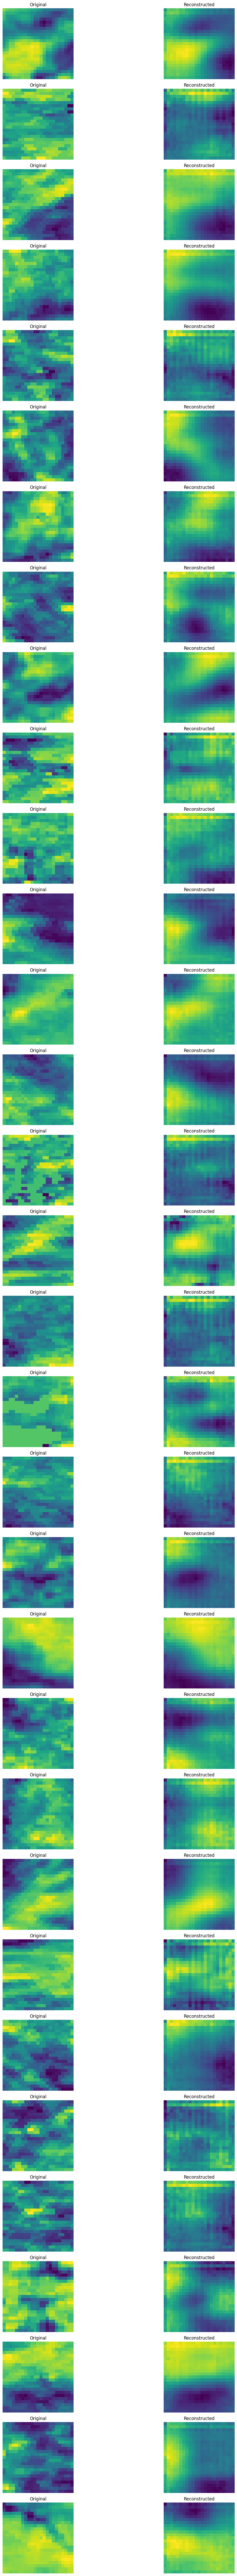

In [ ]:

def compare_vae_reconstructionLST(vae, data_batch, device):
    # Set the VAE to evaluation mode
    vae.eval()

    # Get the batch size and number of channels
    batch_size, num_channels, height, width = data_batch.size()

    # Get the reconstructed images from the VAE
    with torch.no_grad():

        inputs = data_batch

        reconstructed_batch,l, _, _ = vae(inputs.to(device))

    # Convert the tensors to numpy arrays and transpose the dimensions
    original_images = data_batch.cpu().numpy().transpose(0, 2, 3, 1)
    reconstructed_images = reconstructed_batch.cpu().numpy().transpose(0, 2, 3, 1)
    # Plot the original and reconstructed images side by side
    plt.figure(figsize=(100, 100))

    for i in range(batch_size):
        plt.subplot(batch_size, 16, i*16 + 1)
        plt.imshow(original_images[i])
        plt.axis('off')
        plt.title('Original')

        plt.subplot(batch_size, 16, i*16 + 2)
        plt.imshow(reconstructed_images[i])
        plt.axis('off')
        plt.title('Reconstructed')


    plt.tight_layout()
    plt.show()

# Usage
# Assuming 'vae' is your trained Variational Autoencoder model
# and 'data_batch' is your batch of input images
# 'device' should be the device on which your model is (e.g., 'cuda' or 'cpu')
compare_vae_reconstructionLST(vae, randomBatch, device)

In [ ]:
reconstructed_batch,l, _, _ = vae(randomBatch.to(device))

In [ ]:
import numpy as np

In [ ]:
torch.mean(randomBatch)

tensor(14745.7207)

In [ ]:
torch.mean(reconstructed_batch)

tensor(14704.2881, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
import torch.nn.functional as F

def normalize_tensor01(tensor):
    max_val = torch.max(tensor)
    min_val = torch.min(tensor)

    # Avoid division by zero
    if max_val - min_val != 0:
        normalized_tensor = (tensor - min_val) / (max_val - min_val)
    else:
        normalized_tensor = tensor - min_val

    return normalized_tensor

def normalized_mse(tensor1, tensor2):
    # Normalize the tensors
    norm_tensor1 = normalize_tensor01(tensor1)
    norm_tensor2 = normalize_tensor01(tensor2)

    # Compute MSE
    mse_loss_normalized = F.mse_loss(norm_tensor1, norm_tensor2)
    mse_loss =  F.mse_loss(tensor1, tensor2)

    return mse_loss_normalized, mse_loss


In [ ]:
print(normalized_mse(randomBatch.cpu(),reconstructed_batch.cpu()))

(tensor(0.0005, grad_fn=<MseLossBackward0>), tensor(3833.0190, grad_fn=<MseLossBackward0>))


In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader



# Compute average normalized MSE for the first 100 batches
def compute_average_mse(dataloader):
    mse_values = []
    count = 0

    for data in dataloader:
        if count >= 10000:
            break

        # Generate random "predictions" just for the sake of the example
        # In a real scenario, these would be the model's output
        reconstructed_batch,l, _, _ = vae(data.to(device))

        mse,mse2 = normalized_mse(data.cpu(), reconstructed_batch.cpu())
        mse_values.append(mse.item())

        count += 1

    average_mse = sum(mse_values) / len(mse_values)
    print("Average Normalized MSE:", average_mse)

# Example usage
# Replace `your_dataloader` with the DataLoader you have
compute_average_mse(dataLoaderLST)


Average Normalized MSE: 0.001754879145300947
